In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
%matplotlib notebook
import copy
import csv
import glob

In [2]:
FeP_CO = './CO-FeP-8014.csv'
FeP_CO = (pd.read_csv(FeP_CO)).values
data_sets = FeP_CO[:,1:]
print(data_sets.shape,'\n'
      ,data_sets[0,27]
     )
bad_data_set = np.where(data_sets[:,:27]<0)[0]
bad_data_set = np.unique(bad_data_set)
data_sets = np.delete(data_sets,bad_data_set,axis=0)  #删除描述符小于0的样本
print(data_sets.shape,data_sets[0,:])

(8014, 32) 
 34.3839
(7822, 32) [ 0.00000000e+00  7.97749000e+01  7.88000000e-02  5.70100000e-01
  9.12968000e+01  7.80000000e-02  6.02900000e-01  1.90057800e+02
  3.27700000e-01  1.73490000e+00  3.26569200e+02  3.66810000e+00
  1.49500000e-01  3.48180800e+02  3.20490000e+00  1.58600000e-01
  5.05609800e+02  1.39000000e+00  1.62300000e-01  5.35343700e+02
  2.05100000e+00  2.36900000e-01  6.24982200e+02  2.10889000e+01
  2.31570000e+00  2.06517650e+03  6.14578600e+02  3.43839000e+01
 -1.23606292e+01  1.68108900e+00  1.16001000e+00  1.77715561e+02]


In [3]:
x = data_sets[:,1:28]
y_uncomp = data_sets[:,30]
standar_scaler = preprocessing.StandardScaler()                 # 特征数据标准化
x = standar_scaler.fit_transform(x)
print(x[0,:])
scaler = preprocessing.StandardScaler().fit(y_uncomp.reshape(-1,1))#标准化到,scaler保存方差和均值,
y_scaled = preprocessing.scale(y_uncomp.reshape(-1,1))#下次标准化，按scaler2标准化到（mean_=0，var_=1）
y_inver = scaler.inverse_transform(y_scaled)#按scaler2回到原来参数

print(y_uncomp.shape,y_uncomp[:3],'\n','\n'
      ,y_scaled.shape,y_scaled[:3],'\n','\n'
      ,y_inver.shape,y_inver[:3]
     )
data_sets = np.hstack((x,y_scaled))
print(data_sets.shape,data_sets[0,:])

#用固定随机种子打乱二维数组的行顺序
np.random.seed(1)
np.random.shuffle(data_sets)
print(data_sets[0,27])

[-1.30975296  0.83959228  0.12987748 -1.29166525  0.77763446  0.87257407
  0.15253913 -0.46747913 -0.25814035  0.4059082   0.70786827  0.60641935
 -0.04454691 -0.00861144  0.68411636 -1.16957303 -0.57673754 -1.20299624
 -0.78940209 -0.25933814 -0.48590257  0.11753195  0.36320457  0.81970798
  1.35058235  0.84635312  0.14478589]
(7822,) [1.16001  1.191305 1.1582  ] 
 
 (7822, 1) [[-1.23600256]
 [ 1.69457868]
 [-1.40549775]] 
 
 (7822, 1) [[1.16001 ]
 [1.191305]
 [1.1582  ]]
(7822, 28) [-1.30975296  0.83959228  0.12987748 -1.29166525  0.77763446  0.87257407
  0.15253913 -0.46747913 -0.25814035  0.4059082   0.70786827  0.60641935
 -0.04454691 -0.00861144  0.68411636 -1.16957303 -0.57673754 -1.20299624
 -0.78940209 -0.25933814 -0.48590257  0.11753195  0.36320457  0.81970798
  1.35058235  0.84635312  0.14478589 -1.23600256]
0.2078904596823912


In [4]:
k_fold = 5
one_fold = int(data_sets.shape[0]/k_fold)
redundant = data_sets.shape[0] - one_fold*k_fold
print(one_fold,'       ',redundant)
data_sets_1 = data_sets[0:1565,:]
data_sets_2 = data_sets[1565:3130,:]
data_sets_3 = data_sets[3130:4694,:]
data_sets_4 = data_sets[4694:6258,:]
data_sets_5 = data_sets[6258:7822,:]
print(data_sets_1.shape,data_sets_2.shape,data_sets_3.shape,data_sets_4.shape,data_sets_5.shape)

data_sets_new = np.vstack((data_sets_1,data_sets_2))
data_sets_new = np.vstack((data_sets_new,data_sets_3))
data_sets_new = np.vstack((data_sets_new,data_sets_4))
data_sets_new = np.vstack((data_sets_new,data_sets_5))

print((data_sets == data_sets_new).all())
data_sets_train = np.vstack((data_sets_2,data_sets_3))
data_sets_train = np.vstack((data_sets_train,data_sets_4))
data_sets_train = np.vstack((data_sets_train,data_sets_5))
data_sets_test  = data_sets_1
print(data_sets_train.shape,data_sets_test.shape)
x_train = data_sets_train[:,:-1]
y_train = data_sets_train[:,-1]
x_test = data_sets_test[:,:-1]
y_test = data_sets_test[:,-1]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

1564         2
(1565, 28) (1565, 28) (1564, 28) (1564, 28) (1564, 28)
True
(6257, 28) (1565, 28)
(6257, 27) (6257,) (1565, 27) (1565,)


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,input_shape=(x_train.shape[1],),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.03)),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
#     tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(8, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     #tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(256, activation='sigmoid'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(32, activation='relu'),
#     #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,953
Trainable params: 13,953
Non-trainable params: 0
_________________________________________________________________


In [6]:
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.1, decay_steps=80, decay_rate=0.98) #好的效果参数：0.1，80，0.98
model.compile(optimizer=tf.keras.optimizers.Adam(exponential_decay),
              loss='mse',
#               metrics=['acc', 'lr']
             )
print(int(y_train.shape[0]/2+1))

3129


In [7]:
checkpoint_save_path = "./C-O/C-O.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('- - - - - - - - - - - -load the model- - - - - - - - - - - -')
    model.load_weights(checkpoint_save_path)

In [8]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_weights_only=True,
                                                save_best_only=True)

In [9]:
history = model.fit(x_train, y_train, batch_size=y_train.shape[0], epochs=5000, 
                    validation_data=(x_test, y_test), 
                    validation_freq=1,
                    callbacks=[cp_callback]
                   )

Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 4.5257 - val_loss: 64.2751
Epoch 2/5000
1/1 [==============================] - 0s 71ms/step - loss: 63.7824 - val_loss: 66.8657
Epoch 3/5000
1/1 [==============================] - 0s 74ms/step - loss: 69.3535 - val_loss: 661.2859
Epoch 4/5000
1/1 [==============================] - 0s 67ms/step - loss: 631.2816 - val_loss: 299.5312
Epoch 5/5000
1/1 [==============================] - 0s 69ms/step - loss: 280.5440 - val_loss: 9.4337
Epoch 6/5000
1/1 [==============================] - 0s 60ms/step - loss: 9.4484 - val_loss: 9.1826
Epoch 7/5000
1/1 [==============================] - 0s 58ms/step - loss: 9.3194 - val_loss: 12.2162
Epoch 8/5000
1/1 [==============================] - 0s 67ms/step - loss: 12.1798 - val_loss: 14.3100
Epoch 9/5000
1/1 [==============================] - 0s 64ms/step - loss: 14.2812 - val_loss: 23.4600
Epoch 10/5000
1/1 [==============================] - 0s 68ms/step - loss: 23.0059 - val_loss: 

1/1 [==============================] - 0s 70ms/step - loss: 13.0765 - val_loss: 12.8345
Epoch 82/5000
1/1 [==============================] - 0s 72ms/step - loss: 12.8378 - val_loss: 12.6110
Epoch 83/5000
1/1 [==============================] - 0s 74ms/step - loss: 12.6160 - val_loss: 12.3853
Epoch 84/5000
1/1 [==============================] - 0s 62ms/step - loss: 12.3900 - val_loss: 12.1684
Epoch 85/5000
1/1 [==============================] - 0s 66ms/step - loss: 12.1711 - val_loss: 11.9587
Epoch 86/5000
1/1 [==============================] - 0s 68ms/step - loss: 11.9626 - val_loss: 11.7445
Epoch 87/5000
1/1 [==============================] - 0s 75ms/step - loss: 11.7484 - val_loss: 11.5451
Epoch 88/5000
1/1 [==============================] - 0s 65ms/step - loss: 11.5478 - val_loss: 11.3425
Epoch 89/5000
1/1 [==============================] - 0s 49ms/step - loss: 11.3477 - val_loss: 11.1452
Epoch 90/5000
1/1 [==============================] - 0s 61ms/step - loss: 11.1497 - val_loss: 10

1/1 [==============================] - 0s 90ms/step - loss: 3.7745 - val_loss: 3.7215
Epoch 163/5000
1/1 [==============================] - 0s 65ms/step - loss: 3.7243 - val_loss: 3.6722
Epoch 164/5000
1/1 [==============================] - 0s 60ms/step - loss: 3.6750 - val_loss: 3.6238
Epoch 165/5000
1/1 [==============================] - 0s 77ms/step - loss: 3.6266 - val_loss: 3.5762
Epoch 166/5000
1/1 [==============================] - 0s 80ms/step - loss: 3.5791 - val_loss: 3.5294
Epoch 167/5000
1/1 [==============================] - 0s 92ms/step - loss: 3.5323 - val_loss: 3.4834
Epoch 168/5000
1/1 [==============================] - 0s 71ms/step - loss: 3.4863 - val_loss: 3.4381
Epoch 169/5000
1/1 [==============================] - 0s 92ms/step - loss: 3.4412 - val_loss: 3.3937
Epoch 170/5000
1/1 [==============================] - 0s 82ms/step - loss: 3.3968 - val_loss: 3.3502
Epoch 171/5000
1/1 [==============================] - 0s 81ms/step - loss: 3.3536 - val_loss: 3.3083
Epoch

1/1 [==============================] - 0s 64ms/step - loss: 1.4574 - val_loss: 1.4395
Epoch 244/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.4421 - val_loss: 1.4248
Epoch 245/5000
1/1 [==============================] - 0s 62ms/step - loss: 1.4273 - val_loss: 1.4099
Epoch 246/5000
1/1 [==============================] - 0s 51ms/step - loss: 1.4126 - val_loss: 1.3957
Epoch 247/5000
1/1 [==============================] - 0s 54ms/step - loss: 1.3981 - val_loss: 1.3814
Epoch 248/5000
1/1 [==============================] - 0s 69ms/step - loss: 1.3838 - val_loss: 1.3675
Epoch 249/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.3698 - val_loss: 1.3539
Epoch 250/5000
1/1 [==============================] - 0s 109ms/step - loss: 1.3560 - val_loss: 1.3400
Epoch 251/5000
1/1 [==============================] - 0s 81ms/step - loss: 1.3423 - val_loss: 1.3266
Epoch 252/5000
1/1 [==============================] - 0s 103ms/step - loss: 1.3289 - val_loss: 1.3136
Epo

1/1 [==============================] - 0s 95ms/step - loss: 0.7196 - val_loss: 0.7115
Epoch 325/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.7131 - val_loss: 0.7077
Epoch 326/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.7095 - val_loss: 0.7022
Epoch 327/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.7039 - val_loss: 0.6961
Epoch 328/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.6979 - val_loss: 0.6922
Epoch 329/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.6940 - val_loss: 0.6872
Epoch 330/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.6889 - val_loss: 0.6814
Epoch 331/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.6831 - val_loss: 0.6773
Epoch 332/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.6790 - val_loss: 0.6728
Epoch 333/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.6745 - val_loss: 0.6672
Epoch

Epoch 405/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.4378 - val_loss: 0.4355
Epoch 406/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.4369 - val_loss: 0.4342
Epoch 407/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.4356 - val_loss: 0.4298
Epoch 408/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.4311 - val_loss: 0.4281
Epoch 409/5000
1/1 [==============================] - 0s 97ms/step - loss: 0.4294 - val_loss: 0.4271
Epoch 410/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.4284 - val_loss: 0.4236
Epoch 411/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.4248 - val_loss: 0.4211
Epoch 412/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.4223 - val_loss: 0.4201
Epoch 413/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.4214 - val_loss: 0.4176
Epoch 414/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.4188 - val_los

Epoch 486/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.3067 - val_loss: 0.3135
Epoch 487/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.3149 - val_loss: 0.3082
Epoch 488/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.3094 - val_loss: 0.3014
Epoch 489/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.3026 - val_loss: 0.3062
Epoch 490/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.3074 - val_loss: 0.3037
Epoch 491/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.3048 - val_loss: 0.2976
Epoch 492/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.2987 - val_loss: 0.2998
Epoch 493/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.3009 - val_loss: 0.2994
Epoch 494/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.3005 - val_loss: 0.2945
Epoch 495/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.2956 - val_los

1/1 [==============================] - 0s 67ms/step - loss: 0.2525 - val_loss: 0.2588
Epoch 567/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.2606 - val_loss: 0.2317
Epoch 568/5000
1/1 [==============================] - 0s 98ms/step - loss: 0.2329 - val_loss: 0.2436
Epoch 569/5000
1/1 [==============================] - 0s 104ms/step - loss: 0.2448 - val_loss: 0.2522
Epoch 570/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.2538 - val_loss: 0.2294
Epoch 571/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.2304 - val_loss: 0.2395
Epoch 572/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.2407 - val_loss: 0.2452
Epoch 573/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.2468 - val_loss: 0.2264
Epoch 574/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.2275 - val_loss: 0.2367
Epoch 575/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.2377 - val_loss: 0.2396
Epoc

1/1 [==============================] - 0s 81ms/step - loss: 0.1815 - val_loss: 0.1804
Epoch 648/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.1810 - val_loss: 0.1799
Epoch 649/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.1805 - val_loss: 0.1795
Epoch 650/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.1801 - val_loss: 0.1790
Epoch 651/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.1796 - val_loss: 0.1786
Epoch 652/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.1791 - val_loss: 0.1780
Epoch 653/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.1786 - val_loss: 0.1777
Epoch 654/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.1782 - val_loss: 0.1771
Epoch 655/5000
1/1 [==============================] - 0s 43ms/step - loss: 0.1778 - val_loss: 0.1769
Epoch 656/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.1774 - val_loss: 0.1764
Epoch

1/1 [==============================] - 0s 95ms/step - loss: 0.1476 - val_loss: 0.1468
Epoch 729/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.1473 - val_loss: 0.1464
Epoch 730/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.1470 - val_loss: 0.1462
Epoch 731/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.1467 - val_loss: 0.1458
Epoch 732/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.1464 - val_loss: 0.1456
Epoch 733/5000
1/1 [==============================] - 0s 125ms/step - loss: 0.1461 - val_loss: 0.1451
Epoch 734/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.1458 - val_loss: 0.1449
Epoch 735/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.1454 - val_loss: 0.1445
Epoch 736/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.1451 - val_loss: 0.1443
Epoch 737/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.1449 - val_loss: 0.1440
Epoc

1/1 [==============================] - 0s 74ms/step - loss: 0.1232 - val_loss: 0.1223
Epoch 810/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.1229 - val_loss: 0.1222
Epoch 811/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.1227 - val_loss: 0.1220
Epoch 812/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.1226 - val_loss: 0.1220
Epoch 813/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.1225 - val_loss: 0.1221
Epoch 814/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.1227 - val_loss: 0.1225
Epoch 815/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.1230 - val_loss: 0.1234
Epoch 816/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.1240 - val_loss: 0.1252
Epoch 817/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.1257 - val_loss: 0.1286
Epoch 818/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.1293 - val_loss: 0.1344
Epoc

1/1 [==============================] - 0s 70ms/step - loss: 0.1043 - val_loss: 0.1036
Epoch 891/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.1041 - val_loss: 0.1034
Epoch 892/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.1039 - val_loss: 0.1033
Epoch 893/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.1038 - val_loss: 0.1031
Epoch 894/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.1036 - val_loss: 0.1029
Epoch 895/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.1034 - val_loss: 0.1027
Epoch 896/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.1032 - val_loss: 0.1026
Epoch 897/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.1030 - val_loss: 0.1023
Epoch 898/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.1028 - val_loss: 0.1022
Epoch 899/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.1027 - val_loss: 0.1020
Epoch

1/1 [==============================] - 0s 60ms/step - loss: 0.0905 - val_loss: 0.0899
Epoch 972/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0904 - val_loss: 0.0899
Epoch 973/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0903 - val_loss: 0.0897
Epoch 974/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0902 - val_loss: 0.0897
Epoch 975/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0901 - val_loss: 0.0896
Epoch 976/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0901 - val_loss: 0.0896
Epoch 977/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0900 - val_loss: 0.0896
Epoch 978/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0901 - val_loss: 0.0898
Epoch 979/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0901 - val_loss: 0.0899
Epoch 980/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0904 - val_loss: 0.0904
Epoch

1/1 [==============================] - 0s 54ms/step - loss: 0.0865 - val_loss: 0.0887
Epoch 1052/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0893 - val_loss: 0.0914
Epoch 1053/5000
1/1 [==============================] - 0s 44ms/step - loss: 0.0918 - val_loss: 0.0951
Epoch 1054/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0958 - val_loss: 0.0970
Epoch 1055/5000
1/1 [==============================] - 0s 45ms/step - loss: 0.0974 - val_loss: 0.0988
Epoch 1056/5000
1/1 [==============================] - ETA: 0s - loss: 0.099 - 0s 53ms/step - loss: 0.0996 - val_loss: 0.0960
Epoch 1057/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0965 - val_loss: 0.0917
Epoch 1058/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0924 - val_loss: 0.0849
Epoch 1059/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0853 - val_loss: 0.0795
Epoch 1060/5000
1/1 [==============================] - 0s 51ms/step - loss

1/1 [==============================] - 0s 62ms/step - loss: 0.0733 - val_loss: 0.0722
Epoch 1132/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0728 - val_loss: 0.0707
Epoch 1133/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0712 - val_loss: 0.0702
Epoch 1134/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0707 - val_loss: 0.0709
Epoch 1135/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0714 - val_loss: 0.0715
Epoch 1136/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0720 - val_loss: 0.0711
Epoch 1137/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0716 - val_loss: 0.0701
Epoch 1138/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0706 - val_loss: 0.0696
Epoch 1139/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0700 - val_loss: 0.0697
Epoch 1140/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0702 - val_loss: 0.0

1/1 [==============================] - 0s 57ms/step - loss: 0.0638 - val_loss: 0.0632
Epoch 1212/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0636 - val_loss: 0.0630
Epoch 1213/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0634 - val_loss: 0.0629
Epoch 1214/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0633 - val_loss: 0.0629
Epoch 1215/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0633 - val_loss: 0.0629
Epoch 1216/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0633 - val_loss: 0.0630
Epoch 1217/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0633 - val_loss: 0.0630
Epoch 1218/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0634 - val_loss: 0.0631
Epoch 1219/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0634 - val_loss: 0.0631
Epoch 1220/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0635 - val_loss: 0.0

1/1 [==============================] - 0s 58ms/step - loss: 0.0859 - val_loss: 0.0901
Epoch 1292/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0904 - val_loss: 0.0947
Epoch 1293/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0954 - val_loss: 0.0863
Epoch 1294/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0865 - val_loss: 0.0745
Epoch 1295/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0751 - val_loss: 0.0614
Epoch 1296/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0618 - val_loss: 0.0572
Epoch 1297/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0576 - val_loss: 0.0623
Epoch 1298/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0628 - val_loss: 0.0684
Epoch 1299/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0688 - val_loss: 0.0681
Epoch 1300/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0687 - val_loss: 0.0

1/1 [==============================] - 0s 55ms/step - loss: 0.0694 - val_loss: 0.0532
Epoch 1372/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0536 - val_loss: 0.0583
Epoch 1373/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0589 - val_loss: 0.0701
Epoch 1374/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0706 - val_loss: 0.0693
Epoch 1375/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0699 - val_loss: 0.0560
Epoch 1376/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0564 - val_loss: 0.0544
Epoch 1377/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0548 - val_loss: 0.0629
Epoch 1378/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0636 - val_loss: 0.0619
Epoch 1379/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0625 - val_loss: 0.0542
Epoch 1380/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0547 - val_loss: 0.0

1/1 [==============================] - 0s 95ms/step - loss: 0.0490 - val_loss: 0.0486
Epoch 1452/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0490 - val_loss: 0.0488
Epoch 1453/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0491 - val_loss: 0.0488
Epoch 1454/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0492 - val_loss: 0.0490
Epoch 1455/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0493 - val_loss: 0.0491
Epoch 1456/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0496 - val_loss: 0.0497
Epoch 1457/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0499 - val_loss: 0.0502
Epoch 1458/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0506 - val_loss: 0.0512
Epoch 1459/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0515 - val_loss: 0.0526
Epoch 1460/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0532 - val_loss: 0.0

1/1 [==============================] - 0s 80ms/step - loss: 0.0456 - val_loss: 0.0453
Epoch 1532/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0456 - val_loss: 0.0454
Epoch 1533/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0456 - val_loss: 0.0454
Epoch 1534/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0457 - val_loss: 0.0455
Epoch 1535/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0458 - val_loss: 0.0455
Epoch 1536/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0459 - val_loss: 0.0458
Epoch 1537/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0461 - val_loss: 0.0460
Epoch 1538/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 1539/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0468 - val_loss: 0.0471
Epoch 1540/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0474 - val_loss: 0.0

1/1 [==============================] - 0s 83ms/step - loss: 0.1004 - val_loss: 0.1100
Epoch 1612/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.1109 - val_loss: 0.0871
Epoch 1613/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0872 - val_loss: 0.0599
Epoch 1614/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0606 - val_loss: 0.0425
Epoch 1615/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0428 - val_loss: 0.0513
Epoch 1616/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0516 - val_loss: 0.0665
Epoch 1617/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0672 - val_loss: 0.0584
Epoch 1618/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0588 - val_loss: 0.0441
Epoch 1619/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0445 - val_loss: 0.0459
Epoch 1620/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0464 - val_loss: 0.0

1/1 [==============================] - 0s 63ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 1692/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0400 - val_loss: 0.0398
Epoch 1693/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 1694/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0400 - val_loss: 0.0398
Epoch 1695/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 1696/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0400 - val_loss: 0.0398
Epoch 1697/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 1698/5000
1/1 [==============================] - 0s 45ms/step - loss: 0.0400 - val_loss: 0.0397
Epoch 1699/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0399 - val_loss: 0.0395
Epoch 1700/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0399 - val_loss: 0.0

1/1 [==============================] - 0s 49ms/step - loss: 0.0390 - val_loss: 0.0380
Epoch 1772/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0383 - val_loss: 0.0375
Epoch 1773/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0379 - val_loss: 0.0376
Epoch 1774/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 1775/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0383 - val_loss: 0.0381
Epoch 1776/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0384 - val_loss: 0.0378
Epoch 1777/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0381 - val_loss: 0.0374
Epoch 1778/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0378 - val_loss: 0.0373
Epoch 1779/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0376 - val_loss: 0.0374
Epoch 1780/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0377 - val_loss: 0.0

1/1 [==============================] - 0s 54ms/step - loss: 0.0392 - val_loss: 0.0391
Epoch 1852/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0395 - val_loss: 0.0374
Epoch 1853/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0377 - val_loss: 0.0358
Epoch 1854/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0361 - val_loss: 0.0357
Epoch 1855/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0360 - val_loss: 0.0368
Epoch 1856/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0371 - val_loss: 0.0375
Epoch 1857/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0379 - val_loss: 0.0371
Epoch 1858/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 1859/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0364 - val_loss: 0.0354
Epoch 1860/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0358 - val_loss: 0.0

1/1 [==============================] - 0s 74ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 1932/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0372 - val_loss: 0.0353
Epoch 1933/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0357 - val_loss: 0.0340
Epoch 1934/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0344 - val_loss: 0.0346
Epoch 1935/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0350 - val_loss: 0.0356
Epoch 1936/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0360 - val_loss: 0.0355
Epoch 1937/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0358 - val_loss: 0.0344
Epoch 1938/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0348 - val_loss: 0.0339
Epoch 1939/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0342 - val_loss: 0.0343
Epoch 1940/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0346 - val_loss: 0.0

1/1 [==============================] - 0s 73ms/step - loss: 0.0515 - val_loss: 0.0446
Epoch 2012/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0449 - val_loss: 0.0346
Epoch 2013/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0351 - val_loss: 0.0340
Epoch 2014/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0344 - val_loss: 0.0406
Epoch 2015/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0409 - val_loss: 0.0419
Epoch 2016/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0424 - val_loss: 0.0355
Epoch 2017/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0359 - val_loss: 0.0331
Epoch 2018/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0335 - val_loss: 0.0371
Epoch 2019/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0376 - val_loss: 0.0384
Epoch 2020/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0388 - val_loss: 0.0

1/1 [==============================] - 0s 66ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 2092/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2093/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2094/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2095/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2096/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2097/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2098/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 2099/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 2100/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0313 - val_loss: 0.0

1/1 [==============================] - 0s 102ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 2172/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 2173/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 2174/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 2175/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 2176/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 2177/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 2178/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 2179/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0301 - val_loss: 0.0299
Epoch 2180/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0301 - val_loss: 0.

1/1 [==============================] - 0s 56ms/step - loss: 0.0305 - val_loss: 0.0293
Epoch 2252/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0296 - val_loss: 0.0293
Epoch 2253/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0296 - val_loss: 0.0298
Epoch 2254/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 2255/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0303 - val_loss: 0.0295
Epoch 2256/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0299 - val_loss: 0.0291
Epoch 2257/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0294 - val_loss: 0.0292
Epoch 2258/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0295 - val_loss: 0.0295
Epoch 2259/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0298 - val_loss: 0.0296
Epoch 2260/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.0299 - val_loss: 0.0

1/1 [==============================] - 0s 82ms/step - loss: 0.0320 - val_loss: 0.0335
Epoch 2332/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0336 - val_loss: 0.0353
Epoch 2333/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0354 - val_loss: 0.0363
Epoch 2334/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0365 - val_loss: 0.0386
Epoch 2335/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0390 - val_loss: 0.0413
Epoch 2336/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0415 - val_loss: 0.0451
Epoch 2337/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0457 - val_loss: 0.0466
Epoch 2338/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0469 - val_loss: 0.0475
Epoch 2339/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0482 - val_loss: 0.0443
Epoch 2340/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0445 - val_loss: 0.0

1/1 [==============================] - 0s 69ms/step - loss: 0.0422 - val_loss: 0.0504
Epoch 2412/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0510 - val_loss: 0.0590
Epoch 2413/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0592 - val_loss: 0.0726
Epoch 2414/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0733 - val_loss: 0.0759
Epoch 2415/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0761 - val_loss: 0.0777
Epoch 2416/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0786 - val_loss: 0.0584
Epoch 2417/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0586 - val_loss: 0.0386
Epoch 2418/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0392 - val_loss: 0.0275
Epoch 2419/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0278 - val_loss: 0.0328
Epoch 2420/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0330 - val_loss: 0.0

1/1 [==============================] - 0s 73ms/step - loss: 0.0269 - val_loss: 0.0266
Epoch 2492/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0269 - val_loss: 0.0266
Epoch 2493/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0268 - val_loss: 0.0266
Epoch 2494/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0268 - val_loss: 0.0266
Epoch 2495/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 2496/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 2497/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 2498/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 2499/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 2500/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0267 - val_loss: 0.0

1/1 [==============================] - 0s 67ms/step - loss: 0.0270 - val_loss: 0.0269
Epoch 2572/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0272 - val_loss: 0.0265
Epoch 2573/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0268 - val_loss: 0.0261
Epoch 2574/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0264 - val_loss: 0.0261
Epoch 2575/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 2576/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0267 - val_loss: 0.0265
Epoch 2577/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0268 - val_loss: 0.0263
Epoch 2578/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0266 - val_loss: 0.0260
Epoch 2579/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0263 - val_loss: 0.0260
Epoch 2580/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0263 - val_loss: 0.0

1/1 [==============================] - 0s 61ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 2652/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0257 - val_loss: 0.0258
Epoch 2653/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0261 - val_loss: 0.0262
Epoch 2654/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0263 - val_loss: 0.0258
Epoch 2655/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0261 - val_loss: 0.0255
Epoch 2656/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0258 - val_loss: 0.0255
Epoch 2657/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0258 - val_loss: 0.0257
Epoch 2658/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0260 - val_loss: 0.0260
Epoch 2659/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0261 - val_loss: 0.0257
Epoch 2660/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0260 - val_loss: 0.0

1/1 [==============================] - 0s 109ms/step - loss: 0.0252 - val_loss: 0.0250
Epoch 2732/5000
1/1 [==============================] - 0s 136ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 2733/5000
1/1 [==============================] - 0s 118ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 2734/5000
1/1 [==============================] - 0s 100ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 2735/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 2736/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 2737/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 2738/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 2739/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 2740/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0250 - val_loss:

1/1 [==============================] - 0s 136ms/step - loss: 0.0251 - val_loss: 0.0246
Epoch 2812/5000
1/1 [==============================] - 0s 112ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 2813/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 2814/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 2815/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 2816/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0249 - val_loss: 0.0246
Epoch 2817/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0249 - val_loss: 0.0245
Epoch 2818/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 2819/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 2820/5000
1/1 [==============================] - 0s 43ms/step - loss: 0.0246 - val_loss: 

1/1 [==============================] - 0s 55ms/step - loss: 0.0253 - val_loss: 0.0261
Epoch 2892/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0265 - val_loss: 0.0347
Epoch 2893/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0349 - val_loss: 0.0395
Epoch 2894/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0400 - val_loss: 0.0331
Epoch 2895/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0333 - val_loss: 0.0253
Epoch 2896/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0257 - val_loss: 0.0251
Epoch 2897/5000
1/1 [==============================] - 0s 44ms/step - loss: 0.0254 - val_loss: 0.0303
Epoch 2898/5000
1/1 [==============================] - 0s 44ms/step - loss: 0.0306 - val_loss: 0.0320
Epoch 2899/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0325 - val_loss: 0.0273
Epoch 2900/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0276 - val_loss: 0.0

1/1 [==============================] - 0s 66ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2972/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0238 - val_loss: 0.0235
Epoch 2973/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2974/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0238 - val_loss: 0.0235
Epoch 2975/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2976/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2977/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2978/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 2979/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 2980/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0239 - val_loss: 0.0

1/1 [==============================] - 0s 71ms/step - loss: 0.0451 - val_loss: 0.0369
Epoch 3052/5000
1/1 [==============================] - 0s 113ms/step - loss: 0.0372 - val_loss: 0.0254
Epoch 3053/5000
1/1 [==============================] - 0s 153ms/step - loss: 0.0257 - val_loss: 0.0250
Epoch 3054/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0254 - val_loss: 0.0328
Epoch 3055/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0331 - val_loss: 0.0337
Epoch 3056/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0342 - val_loss: 0.0260
Epoch 3057/5000
1/1 [==============================] - 0s 113ms/step - loss: 0.0263 - val_loss: 0.0242
Epoch 3058/5000
1/1 [==============================] - 0s 176ms/step - loss: 0.0245 - val_loss: 0.0293
Epoch 3059/5000
1/1 [==============================] - 0s 91ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 3060/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0299 - val_loss:

1/1 [==============================] - 0s 60ms/step - loss: 0.0231 - val_loss: 0.0229
Epoch 3132/5000
1/1 [==============================] - ETA: 0s - loss: 0.023 - 0s 77ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3133/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3134/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3135/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3136/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3137/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 3138/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 3139/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 3140/5000
1/1 [==============================] - 0s 63ms/step - loss

1/1 [==============================] - 0s 54ms/step - loss: 0.0847 - val_loss: 0.0834
Epoch 3212/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0848 - val_loss: 0.0528
Epoch 3213/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0530 - val_loss: 0.0280
Epoch 3214/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 3215/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0255 - val_loss: 0.0396
Epoch 3216/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0399 - val_loss: 0.0473
Epoch 3217/5000
1/1 [==============================] - 0s 46ms/step - loss: 0.0480 - val_loss: 0.0338
Epoch 3218/5000
1/1 [==============================] - 0s 47ms/step - loss: 0.0340 - val_loss: 0.0240
Epoch 3219/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0242 - val_loss: 0.0296
Epoch 3220/5000
1/1 [==============================] - 0s 48ms/step - loss: 0.0301 - val_loss: 0.0

1/1 [==============================] - 0s 80ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3292/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3293/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3294/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3295/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3296/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0225 - val_loss: 0.0223
Epoch 3297/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 3298/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 3299/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 3300/5000
1/1 [==============================] - 0s 114ms/step - loss: 0.0225 - val_loss: 0.

1/1 [==============================] - 0s 55ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 3372/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 3373/5000
1/1 [==============================] - 0s 45ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 3374/5000
1/1 [==============================] - 0s 41ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 3375/5000
1/1 [==============================] - 0s 40ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 3376/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 3377/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 3378/5000
1/1 [==============================] - 0s 51ms/step - loss: 0.0227 - val_loss: 0.0228
Epoch 3379/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0231 - val_loss: 0.0235
Epoch 3380/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0236 - val_loss: 0.0

1/1 [==============================] - 0s 109ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3452/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3453/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3454/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3455/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3456/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3457/5000
1/1 [==============================] - 0s 136ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3458/5000
1/1 [==============================] - 0s 155ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3459/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 3460/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0220 - val_loss: 

1/1 [==============================] - 0s 54ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 3532/5000
1/1 [==============================] - 0s 45ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3533/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3534/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3535/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3536/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 3537/5000
1/1 [==============================] - 0s 52ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3538/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 3539/5000
1/1 [==============================] - 0s 79ms/step - loss: 0.0217 - val_loss: 0.0214
Epoch 3540/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0217 - val_loss: 0.0

1/1 [==============================] - 0s 57ms/step - loss: 0.0588 - val_loss: 0.0635
Epoch 3612/5000
1/1 [==============================] - 0s 90ms/step - loss: 0.0641 - val_loss: 0.0523
Epoch 3613/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0524 - val_loss: 0.0380
Epoch 3614/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0385 - val_loss: 0.0243
Epoch 3615/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0245 - val_loss: 0.0221
Epoch 3616/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0223 - val_loss: 0.0296
Epoch 3617/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0299 - val_loss: 0.0352
Epoch 3618/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0354 - val_loss: 0.0328
Epoch 3619/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0331 - val_loss: 0.0244
Epoch 3620/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0246 - val_loss: 0.0

1/1 [==============================] - 0s 54ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3692/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3693/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3694/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3695/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3696/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3697/5000
1/1 [==============================] - 0s 49ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3698/5000
1/1 [==============================] - 0s 103ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3699/5000
1/1 [==============================] - 0s 166ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3700/5000
1/1 [==============================] - 0s 110ms/step - loss: 0.0212 - val_loss: 

1/1 [==============================] - 0s 87ms/step - loss: 0.0212 - val_loss: 0.0209
Epoch 3772/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0211 - val_loss: 0.0213
Epoch 3773/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0214 - val_loss: 0.0214
Epoch 3774/5000
1/1 [==============================] - 0s 112ms/step - loss: 0.0216 - val_loss: 0.0213
Epoch 3775/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0215 - val_loss: 0.0210
Epoch 3776/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 3777/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 3778/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0215 - val_loss: 0.0214
Epoch 3779/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 3780/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0215 - val_loss: 0

1/1 [==============================] - 0s 93ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3852/5000
1/1 [==============================] - 0s 108ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3853/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3854/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3855/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3856/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3857/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3858/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3859/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3860/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0208 - val_loss: 0.

1/1 [==============================] - 0s 66ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 3932/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3933/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 3934/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0208 - val_loss: 0.0205
Epoch 3935/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0207 - val_loss: 0.0204
Epoch 3936/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 3937/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 3938/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 3939/5000
1/1 [==============================] - 0s 53ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 3940/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0207 - val_loss: 0.0

1/1 [==============================] - 0s 69ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4012/5000
1/1 [==============================] - ETA: 0s - loss: 0.020 - 0s 63ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4013/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4014/5000
1/1 [==============================] - 0s 72ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4015/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4016/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4017/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4018/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4019/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 4020/5000
1/1 [==============================] - 0s 78ms/step - loss

1/1 [==============================] - 0s 62ms/step - loss: 0.0207 - val_loss: 0.0204
Epoch 4092/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0207 - val_loss: 0.0207
Epoch 4093/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0210 - val_loss: 0.0206
Epoch 4094/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0209 - val_loss: 0.0203
Epoch 4095/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0206 - val_loss: 0.0204
Epoch 4096/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 4097/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 4098/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 4099/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0205 - val_loss: 0.0203
Epoch 4100/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0206 - val_loss: 0.0

1/1 [==============================] - 0s 62ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4172/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4173/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4174/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4175/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4176/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4177/5000
1/1 [==============================] - 0s 109ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4178/5000
1/1 [==============================] - 0s 85ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4179/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 4180/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0201 - val_loss: 0.

1/1 [==============================] - 0s 75ms/step - loss: 0.0200 - val_loss: 0.0197
Epoch 4252/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 4253/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0200 - val_loss: 0.0198
Epoch 4254/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 4255/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0200 - val_loss: 0.0197
Epoch 4256/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0199 - val_loss: 0.0197
Epoch 4257/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 4258/5000
1/1 [==============================] - 0s 86ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 4259/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0200 - val_loss: 0.0198
Epoch 4260/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0199 - val_loss: 0.0

1/1 [==============================] - 0s 61ms/step - loss: 0.0227 - val_loss: 0.0291
Epoch 4332/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0292 - val_loss: 0.0317
Epoch 4333/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0321 - val_loss: 0.0264
Epoch 4334/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0265 - val_loss: 0.0206
Epoch 4335/5000
1/1 [==============================] - 0s 56ms/step - loss: 0.0208 - val_loss: 0.0203
Epoch 4336/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0206 - val_loss: 0.0243
Epoch 4337/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0245 - val_loss: 0.0260
Epoch 4338/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0264 - val_loss: 0.0229
Epoch 4339/5000
1/1 [==============================] - 0s 62ms/step - loss: 0.0231 - val_loss: 0.0198
Epoch 4340/5000
1/1 [==============================] - 0s 50ms/step - loss: 0.0201 - val_loss: 0.0

1/1 [==============================] - 0s 68ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4412/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4413/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4414/5000
1/1 [==============================] - 0s 74ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4415/5000
1/1 [==============================] - 0s 94ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4416/5000
1/1 [==============================] - 0s 88ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4417/5000
1/1 [==============================] - 0s 78ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4418/5000
1/1 [==============================] - 0s 68ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4419/5000
1/1 [==============================] - 0s 84ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4420/5000
1/1 [==============================] - 0s 82ms/step - loss: 0.0196 - val_loss: 0.0

1/1 [==============================] - 0s 64ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4492/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4493/5000
1/1 [==============================] - 0s 95ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4494/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4495/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4496/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4497/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4498/5000
1/1 [==============================] - 0s 63ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4499/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4500/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0194 - val_loss: 0.0

1/1 [==============================] - 0s 70ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 4572/5000
1/1 [==============================] - 0s 70ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 4573/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4574/5000
1/1 [==============================] - 0s 59ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4575/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4576/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4577/5000
1/1 [==============================] - 0s 81ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4578/5000
1/1 [==============================] - 0s 99ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4579/5000
1/1 [==============================] - 0s 132ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 4580/5000
1/1 [==============================] - 0s 114ms/step - loss: 0.0193 - val_loss: 0

1/1 [==============================] - 0s 84ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4652/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4653/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4654/5000
1/1 [==============================] - ETA: 0s - loss: 0.019 - 0s 84ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4655/5000
1/1 [==============================] - 0s 92ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4656/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4657/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4658/5000
1/1 [==============================] - 0s 75ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 4659/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0191 - val_loss: 0.0190
Epoch 4660/5000
1/1 [==============================] - 0s 71ms/step - los

1/1 [==============================] - 0s 75ms/step - loss: 0.0414 - val_loss: 0.0347
Epoch 4732/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0351 - val_loss: 0.0249
Epoch 4733/5000
1/1 [==============================] - 0s 87ms/step - loss: 0.0250 - val_loss: 0.0192
Epoch 4734/5000
1/1 [==============================] - 0s 89ms/step - loss: 0.0194 - val_loss: 0.0202
Epoch 4735/5000
1/1 [==============================] - 0s 107ms/step - loss: 0.0204 - val_loss: 0.0250
Epoch 4736/5000
1/1 [==============================] - 0s 102ms/step - loss: 0.0251 - val_loss: 0.0281
Epoch 4737/5000
1/1 [==============================] - 0s 102ms/step - loss: 0.0284 - val_loss: 0.0257
Epoch 4738/5000
1/1 [==============================] - 0s 101ms/step - loss: 0.0258 - val_loss: 0.0210
Epoch 4739/5000
1/1 [==============================] - 0s 83ms/step - loss: 0.0213 - val_loss: 0.0189
Epoch 4740/5000
1/1 [==============================] - 0s 73ms/step - loss: 0.0191 - val_loss:

1/1 [==============================] - 0s 90ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 4812/5000
1/1 [==============================] - 0s 80ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 4813/5000
1/1 [==============================] - 0s 115ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 4814/5000
1/1 [==============================] - 0s 93ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4815/5000
1/1 [==============================] - 0s 77ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4816/5000
1/1 [==============================] - 0s 96ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4817/5000
1/1 [==============================] - 0s 118ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4818/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4819/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4820/5000
1/1 [==============================] - 0s 66ms/step - loss: 0.0188 - val_loss: 0

1/1 [==============================] - 0s 60ms/step - loss: 0.0187 - val_loss: 0.0185
Epoch 4892/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0187 - val_loss: 0.0185
Epoch 4893/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 4894/5000
1/1 [==============================] - 0s 69ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 4895/5000
1/1 [==============================] - 0s 71ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 4896/5000
1/1 [==============================] - 0s 76ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 4897/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 4898/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0189 - val_loss: 0.0189
Epoch 4899/5000
1/1 [==============================] - 0s 61ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 4900/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0193 - val_loss: 0.0

1/1 [==============================] - 0s 58ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4971/5000
1/1 [==============================] - 0s 54ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4972/5000
1/1 [==============================] - 0s 67ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4973/5000
1/1 [==============================] - 0s 57ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4974/5000
1/1 [==============================] - 0s 64ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4975/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4976/5000
1/1 [==============================] - 0s 58ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4977/5000
1/1 [==============================] - 0s 60ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4978/5000
1/1 [==============================] - 0s 55ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 4979/5000
1/1 [==============================] - 0s 65ms/step - loss: 0.0186 - val_loss: 0.0

In [13]:
history.history.keys()
# history.history.get('loss')[0:]

dict_keys(['loss', 'val_loss'])

<IPython.core.display.Javascript object>


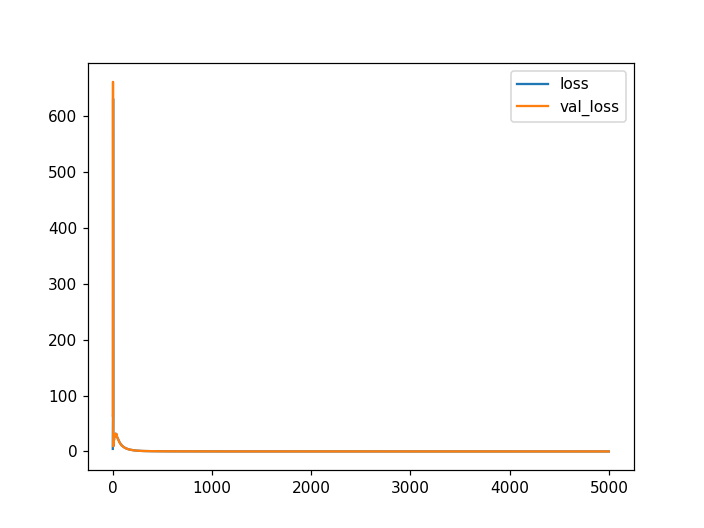

In [14]:
plt.figure()
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()
plt.show()
#plt.savefig('loss.jpg')

In [15]:
model.load_weights( "./C-O/C-O.ckpt")
y_train_predict_scaled = model.predict(x_train)
y_train_predict_scaled = np.array(y_train_predict_scaled).flatten()
y_test_predict_scaled = model.predict(x_test)
y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
print(y_train.shape)
print(y_train_predict_scaled.shape)

(6257,)
(6257,)


In [16]:
y_train_invers = np.array(scaler.inverse_transform(y_train)).flatten()
y_test_invers = np.array(scaler.inverse_transform(y_test)).flatten()
y_train_predict_invers = np.array(scaler.inverse_transform(y_train_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()
print(y_train_invers.shape,y_test_invers.shape,y_train_predict_invers.shape,y_test_predict_invers.shape)

(6257,) (1565,) (6257,) (1565,)


<IPython.core.display.Javascript object>


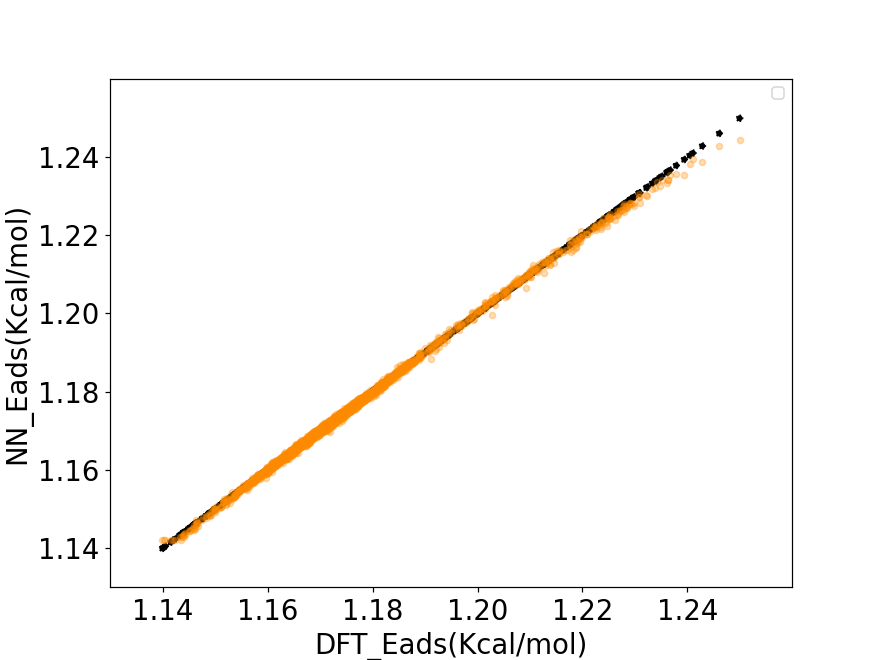

No handles with labels found to put in legend.


In [17]:
plt.figure(figsize=(8,6))
scale = 0.01
plt.xlim(min(y_train_invers)-scale,max(y_train_invers)+scale)
plt.ylim(min(y_train_invers)-scale,max(y_train_invers)+scale)

plt.scatter(y_train_invers,y_train_invers, color='black', s=16,linestyle='dotted')
plt.scatter(y_train_invers, y_train_predict_invers, s=16, alpha=0.3,color='darkorange')

plt.xlabel('DFT_Eads(Kcal/mol)',fontsize=18)
plt.ylabel('NN_Eads(Kcal/mol)',fontsize=18)

x1 = np.arange(min(y_train_invers),max(y_train_invers),0.5)
# plt.plot(x1,x1-3.6,label='y=x-3.6')
# plt.legend()

plt.xticks(fontsize=18,rotation=0)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig('./C-O/Train.png')

<IPython.core.display.Javascript object>


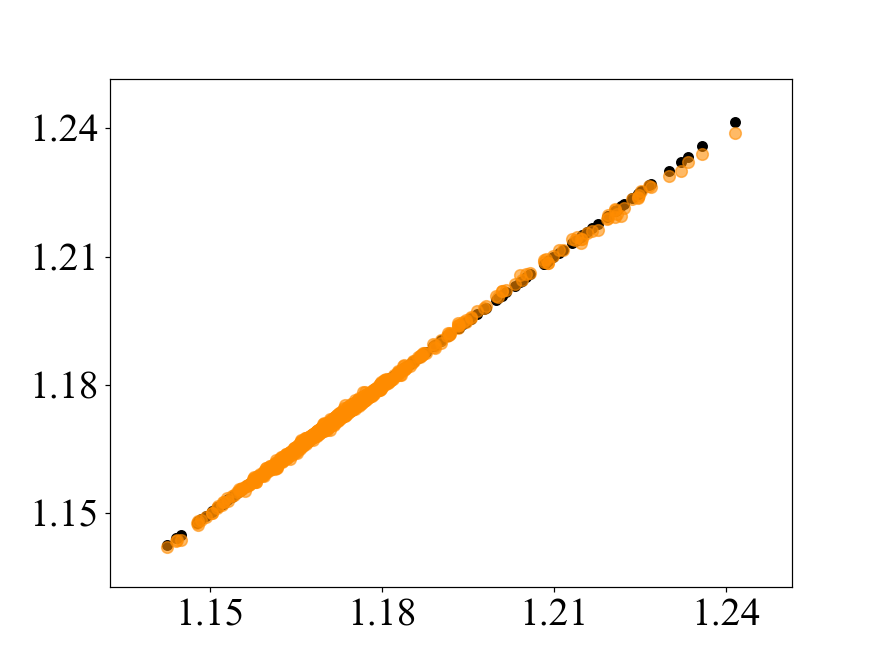

In [18]:
plt.figure(num=3,figsize=(8,6))
plt.rc('font',family='Times New Roman') 
scale = 0.01
plt.xlim(min(y_test_invers)-scale,max(y_test_invers)+scale)
plt.ylim(min(y_test_invers)-scale,max(y_test_invers)+scale)


plt.scatter(y_test_invers,y_test_invers, color='black', s=38
#             ,linestyle='dotted'
           )
plt.scatter(y_test_invers,y_test_predict_invers, s=58, alpha=0.6,color='darkorange')

# plt.xlabel('DFT',fontsize=24)
# plt.ylabel('NN',fontsize=24)
plt.xticks(np.arange(1.15,1.24,0.03),fontsize=26,rotation=0)
plt.yticks(np.arange(1.15,1.24,0.03),fontsize=26)

# plt.xticks(np.arange(1.60,max(y_test_invers)+scale,0.05),fontsize=22,rotation=0)
# plt.yticks(np.arange(1.60,max(y_test_invers)+scale,0.05),fontsize=22)

plt.savefig('./C-O/Test.png', dpi=168, bbox_inches='tight')

In [19]:
import sklearn.metrics as sm
print("训练集------MAE: ",sm.mean_absolute_error(y_train_invers,y_train_predict_invers))
print("测试集------MAE: ",sm.mean_absolute_error(y_test_invers,y_test_predict_invers))
print("训练集------MSE: ",sm.mean_squared_error(y_train_invers,y_train_predict_invers))
print("测试集------MSE: ",sm.mean_squared_error(y_test_invers,y_test_predict_invers))
print("训练集------RMSE: ",np.sqrt(sm.mean_squared_error(y_train_invers,y_train_predict_invers)))
print("测试集------RMSE:: ",np.sqrt(sm.mean_squared_error(y_test_invers,y_test_predict_invers)))
print("训练集------R2_score: ",sm.r2_score(y_train_invers,y_train_predict_invers))
print("测试集------R2_score:: ",sm.r2_score(y_test_invers,y_test_predict_invers))

训练集------MAE:  0.00027972263235098835
测试集------MAE:  0.0002764652512376709
训练集------MSE:  1.6433229753362426e-07
测试集------MSE:  1.4343466889906896e-07
训练集------RMSE:  0.0004053792021473527
测试集------RMSE::  0.00037872769755996057
训练集------R2_score:  0.9985967010397859
测试集------R2_score::  0.9985901873991819


In [20]:
import sklearn.metrics as sm
random_x_test = np.random.permutation(x_test) 
y_test_invers = np.array(scaler.inverse_transform(y_test)).flatten()
print(x_test[0,0])
train_mae = []
test_mae = []
for i in range(1):
    new_x_test = x_test.copy()   #如果直接用等号，那么new_data_sets和data_sets会指向同一个地址，改变一个另一个也变
    new_x_test[:,i] = random_x_test[:,i]
    
    y_test_predict_scaled = model.predict(new_x_test)
    y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
    y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
    mae = sm.mean_absolute_error(y_test_invers,y_test_predict_invers)
    test_mae.append(mae)
    
y_test_predict_scaled = model.predict(x_test)
y_test_predict_scaled = np.array(y_test_predict_scaled).flatten()
y_test_predict_invers  = np.array(scaler.inverse_transform(y_test_predict_scaled.reshape(-1,1))).flatten()#按scaler2回到原来参数
mae = sm.mean_absolute_error(y_test_invers,y_test_predict_invers)

print(x_test[0,0])
test_mae.append(mae)
print(len(test_mae),test_mae)

0.06675638550406471
0.06675638550406471
2 [0.00029375698855951934, 0.0002764652512376709]
